In [1]:
#%pip install mrcfile

In [2]:
#%pip install opencv-python

In [3]:
#%pip install scikit-image

In [4]:
#%pip install matplotlib

In [5]:
#%pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"

In [6]:
#%pip install gdown

In [7]:
#%pip install "denoising @ git+https://github.com/vicente-gonzalez-ruiz/denoising"
!rm denoising
!ln -s ../../src/denoising denoising

rm: cannot remove 'denoising': No such file or directory


In [8]:
#use_OpenCV = True
#local_debug = True

In [9]:
import logging
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#from ipywidgets import *
import cv2
import time
#import kernels
import skimage
#from skimage import io as skimage_io
import mrcfile
import logging
from collections import namedtuple
import information_theory
from denoising.volume.gaussian import Monochrome_Denoising as GF

In [10]:
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [11]:
%%bash
ln -sf /nas/vruiz/vols/empiar10311_stack_crop.mrc .

In [12]:
vol_filename = "empiar10311_stack_crop.mrc"

In [13]:
Args = namedtuple("args", ["input", "output"])
fn, fe = vol_filename.split(".")
args = Args(vol_filename , fn + "_denoised." + fe)
print(args)

args(input='empiar10311_stack_crop.mrc', output='empiar10311_stack_crop_denoised.mrc')


In [14]:
#noisy = skimage.io.imread(args.input, plugin="tifffile").astype(np.float32)
stack_MRC = mrcfile.open(args.input)
noisy = stack_MRC.data

In [15]:
Z_dim = noisy.shape[0]
Z2 = Z_dim//2

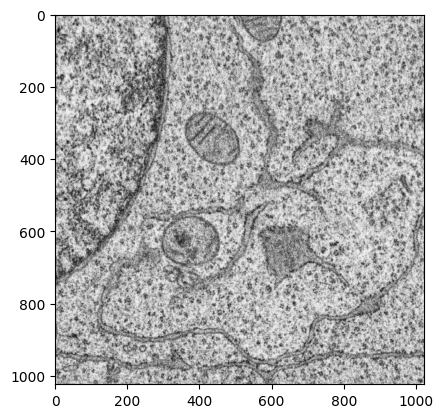

In [16]:
plt.imshow(noisy[Z2], cmap="gray")

In [17]:
def get_gaussian_kernel(sigma=1):
    number_of_coeffs = 3
    number_of_zeros = 0
    while number_of_zeros < 2 :
        delta = np.zeros(number_of_coeffs)
        delta[delta.size//2] = 1
        coeffs = scipy.ndimage.gaussian_filter1d(delta, sigma=sigma)
        number_of_zeros = coeffs.size - np.count_nonzero(coeffs)
        number_of_coeffs += 1
    return coeffs[1:-1]

std_dev = 2.0
sigma = np.array([std_dev, std_dev, std_dev])
kernel = [None]*3
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
kernel[2] = get_gaussian_kernel(sigma[2])

In [18]:
denoiser = GF(logger)
denoised = denoiser.filter(noisy, kernel)

[gaussian.py:99 filter()] mean=164.70201110839844
[gaussian.py:101 filter()] filtered along Z
[gaussian.py:103 filter()] filtered along Y
[gaussian.py:105 filter()] filtered along X


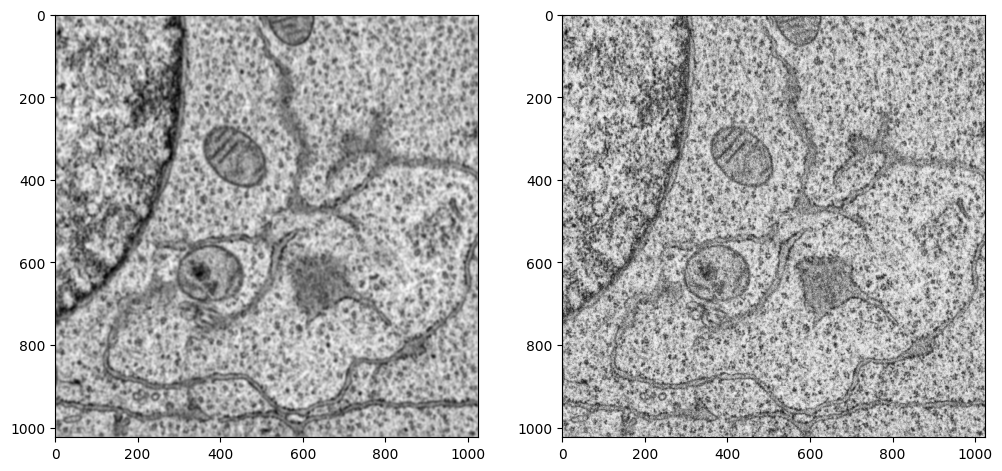

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(denoised[Z2], cmap="gray")
axes[1].imshow(noisy[Z2], cmap="gray")
plt.show()

In [20]:
with mrcfile.new(f"denoised.mrc", overwrite=True) as mrc:
    mrc.set_data(denoised.astype(np.float32))
    mrc.data